###Imports (после пип инсталлов рестартнуть среду)

In [ ]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade albumentations
!pip install --upgrade git+https://github.com/albumentations-team/albumentations
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

!pip install pytorch_lightning
!pip install transformers

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from transformers import CLIPProcessor, CLIPModel, AutoModel, TFCLIPModel

from PIL import Image, ImageShow, ImageDraw
from skimage import io

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms, utils
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from sklearn.model_selection import train_test_split

import json

import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import albumentations as album
import segmentation_models_pytorch as smp

### Defining train / val / test directories 📁

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data

!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/test data
!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/test_labels data
!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/val data
!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/val_labels data
!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/train data
!cp -r drive/MyDrive/'Дипломный проект'/datasets/my_dataset/train_labels data

Resize photos and masks

In [ ]:
from PIL import Image

for image, mask in zip(os.listdir('data/test'), os.listdir('data/test_labels')):
    img = Image.open(os.path.join('data/test', image)).resize((1500, 1500), Image.ANTIALIAS)
    mask = Image.open(os.path.join('data/test_labels', mask)).resize((1500, 1500), Image.ANTIALIAS)

    img.save(os.path.join('data/test', image))
    mask.save(os.path.join('data/test_labels', image))

for image, mask in zip(os.listdir('data/val'), os.listdir('data/val_labels')):
    img = Image.open(os.path.join('data/val', image)).resize((1500, 1500), Image.ANTIALIAS)
    mask = Image.open(os.path.join('data/val_labels', mask)).resize((1500, 1500), Image.ANTIALIAS)

    img.save(os.path.join('data/val', image))
    mask.save(os.path.join('data/val_labels', image))

for image, mask in zip(os.listdir('data/train'), os.listdir('data/train_labels')):
    img = Image.open(os.path.join('data/train', image)).resize((1500, 1500), Image.ANTIALIAS)
    mask = Image.open(os.path.join('data/train_labels', mask)).resize((1500, 1500), Image.ANTIALIAS)

    img.save(os.path.join('data/train', image))
    mask.save(os.path.join('data/train_labels', image))

In [ ]:
# DATA_DIR = 'drive/MyDrive/Дипломный проект/datasets/mas-roofs/'
DATA_DIR = 'data'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
data = {'name': ['background', 'building'], 'r': [0, 255], 'g': [0, 255], 'b': [0, 255]}
class_dict = pd.DataFrame(data=data)

In [ ]:
# class_dict = pd.read_csv("drive/MyDrive/Дипломный проект/datasets/mas-roofs/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


###PytorchLightning classes

In [ ]:
# MODEL = "openai/clip-vit-base-patch32"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 30

In [ ]:
class AutoModelResNet101(pl.LightningModule):

    def __init__(self, learning_rate: float = 3e-5):
        super(AutoModelResNet101, self).__init__()
        
        self.model = smp.DeepLabV3Plus(
            encoder_name=ENCODER, 
            encoder_weights=ENCODER_WEIGHTS, 
            classes=len(CLASSES), 
            activation=ACTIVATION)
        
        self.save_hyperparameters("learning_rate")

    def forward(self, x):
        outputs = self.model(x)

        return outputs

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y, reduction="mean")

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y, reduction="mean")

        return loss

    def validation_epoch_end(self, outputs):
        # avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_loss = outputs[0]
        self.log('val_loss', avg_loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

        return optimizer

In [ ]:
class ResNetDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [ ]:
class ResNetDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4):
        super().__init__()
        self.batch_size = batch_size

    def insert_data(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

In [ ]:
list_of_train = []
list_of_train_labels = []
list_of_val = []
list_of_val_labels = []
list_of_test = []
list_of_test_labels = []

# list_of_polygons = []

path_to_train = 'data/train'
path_to_train_labels = 'data/train_labels'
path_to_val = 'data/val'
path_to_val_labels = 'data/val_labels'
path_to_test = 'data/test'
path_to_test_labels = 'data/test_labels'

for image, mask in zip(os.listdir(path_to_train), os.listdir(path_to_train_labels)):
    list_of_train.append(os.path.join(path_to_train, image))
    list_of_train_labels.append(os.path.join(path_to_train_labels, mask))

for image, mask in zip(os.listdir(path_to_val), os.listdir(path_to_val_labels)):
    list_of_val.append(os.path.join(path_to_val, image))
    list_of_val_labels.append(os.path.join(path_to_val_labels, mask))

for image, mask in zip(os.listdir(path_to_test), os.listdir(path_to_test_labels)):
    list_of_test.append(os.path.join(path_to_test, image))
    list_of_test_labels.append(os.path.join(path_to_test_labels, mask))

In [ ]:
dataframe_train = pd.DataFrame()
dataframe_train['train'] = list_of_train
dataframe_train['train_labels'] = list_of_train_labels

dataframe_val = pd.DataFrame()
# dataframe_val['val'] = list_of_val
# dataframe_val['val_labels'] = list_of_val_labels

dataframe_val['val'] = list_of_test
dataframe_val['val_labels'] = list_of_test_labels
# dataframe['polygons'] = list_of_polygons

In [ ]:
# train_dataframe = dataframe_train[:int(len(dataframe_train) * 0.9)]
# val_dataframe = dataframe_val[int(len(dataframe_val) * 0.9):]

# train_dataset = ResNetDataset(train_dataframe)
# val_dataset = ResNetDataset(val_dataframe)

#### Helper functions for viz. & one-hot encoding/decoding

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Visualize Sample Image and Mask 📈

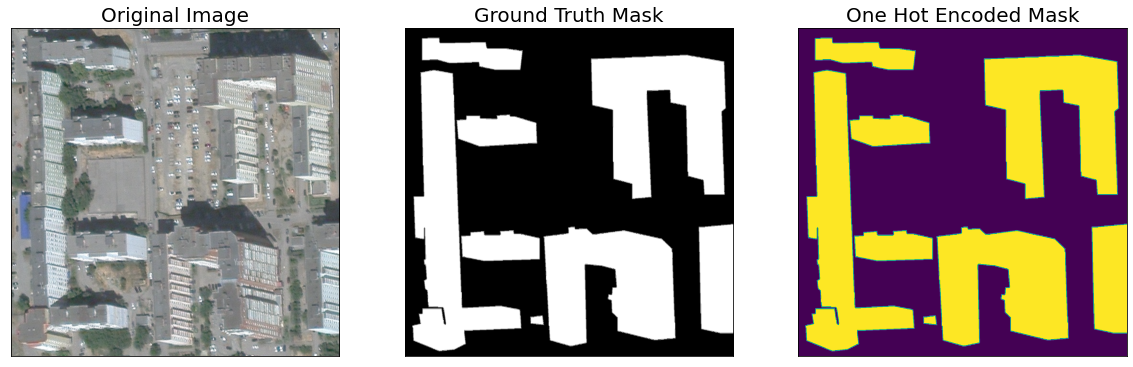

In [ ]:
dataset = ResNetDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

#### Defining Augmentations 🙃

In [ ]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

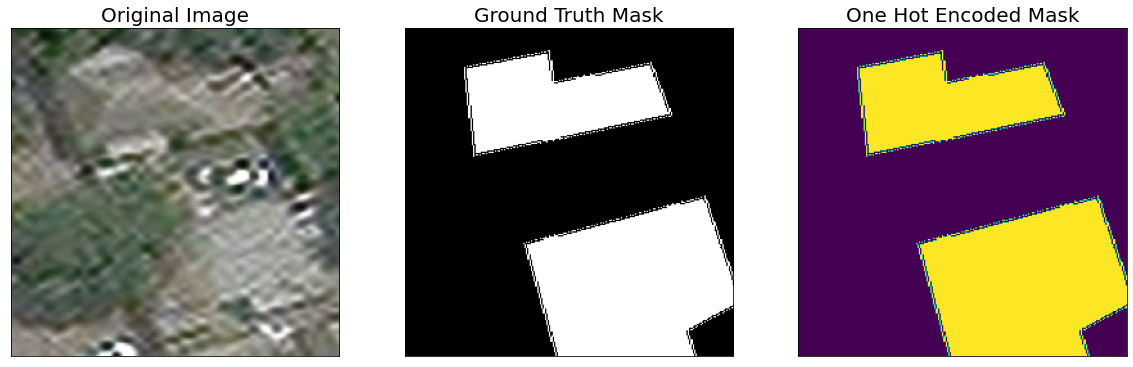

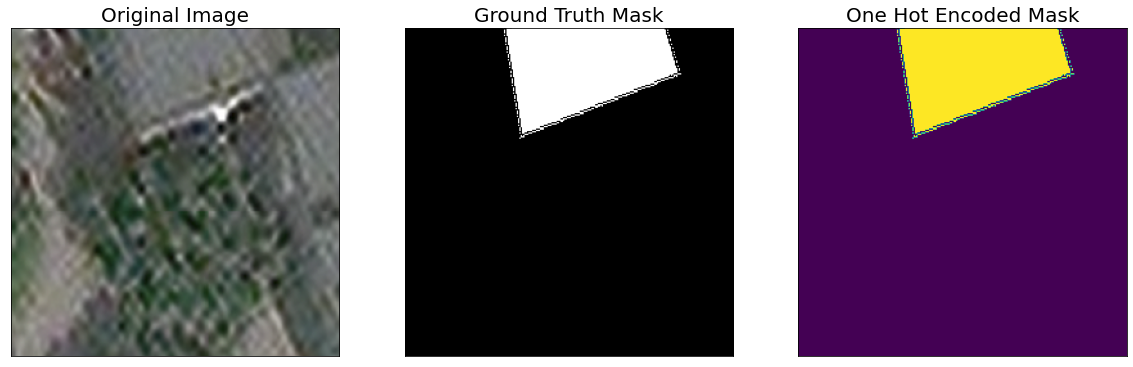

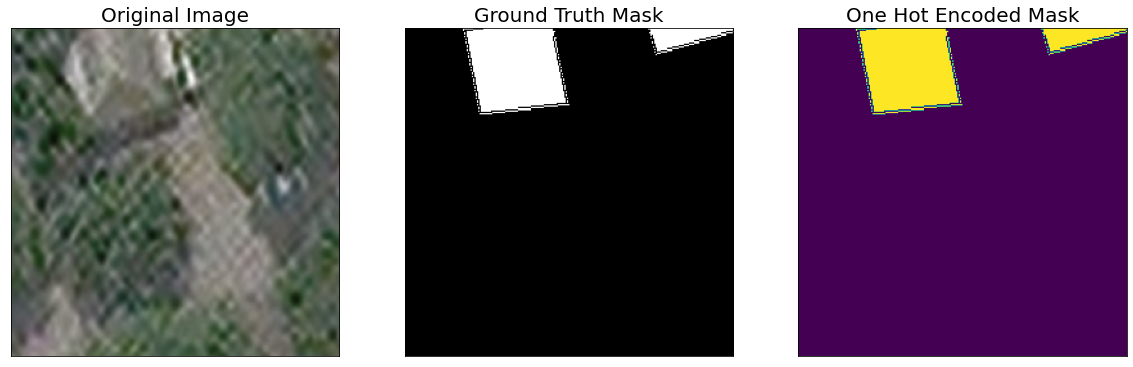

In [ ]:
augmented_dataset = ResNetDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## ---Training DeepLabV3+ with Pretrained ResNet101 Encoder

#### Get Train / Val DataLoaders

In [ ]:
# Get train and val dataset instances
train_dataset = ResNetDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = ResNetDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5)
# valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
data_loaders = ResNetDataModule(batch_size=BATCH_SIZE)
data_loaders.insert_data(train_dataset, valid_dataset)
# data_loaders.insert_data(train_loader, valid_loader)

Find optimal learning rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_ca3d9771-0048-4f75-b9e6-6a38b01a4dce.ckpt


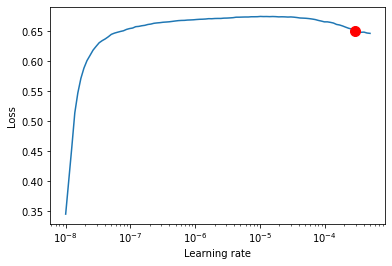

In [ ]:
# data_transforms = transforms.Compose([transforms.ToTensor()])
model = AutoModelResNet101(LEARNING_RATE)

trainer = pl.Trainer(
    gpus=-1,
    auto_lr_find=True,
    val_check_interval=0.5,
    log_every_n_steps=1,
    max_epochs=EPOCHS,
)

lr_finder = trainer.tuner.lr_find(model=model, datamodule=data_loaders, num_training=100, max_lr=5e-4)
fig = lr_finder.plot(suggest=True)
fig.show()

Training model

In [ ]:
model.hparams.learning_rate = lr_finder.suggestion()

trainer.fit(model, data_loaders)
trainer.save_checkpoint("model.ckpt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 45.7 M
----------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.680   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
!cp model.ckpt drive/MyDrive/'Дипломный проект'/'trained models'/model_18_07_22.ckpt

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
# if os.path.exists('drive/MyDrive/Дипломный проект/best_model.pth'):
best_model = torch.load('drive/MyDrive/Дипломный проект/best_model_18_07_2022.pth', map_location=DEVICE)
print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
#     best_model = torch.load('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


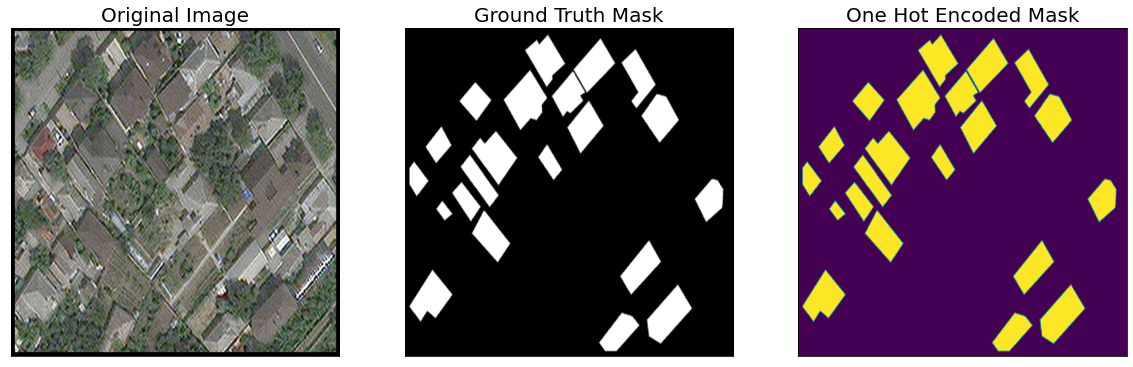

In [ ]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = ResNetDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = ResNetDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

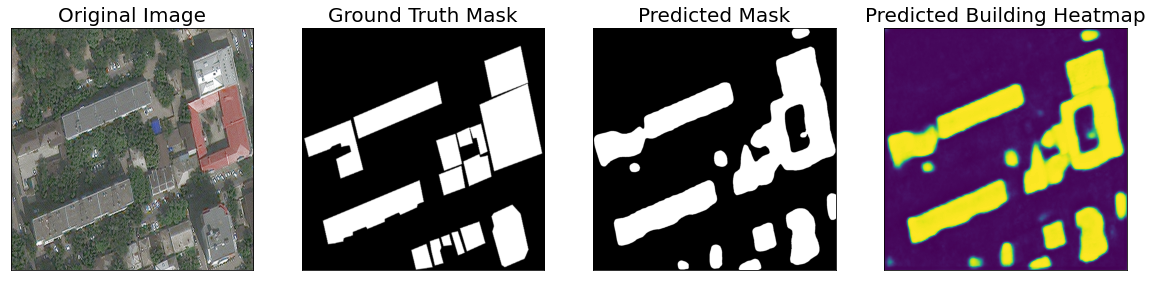

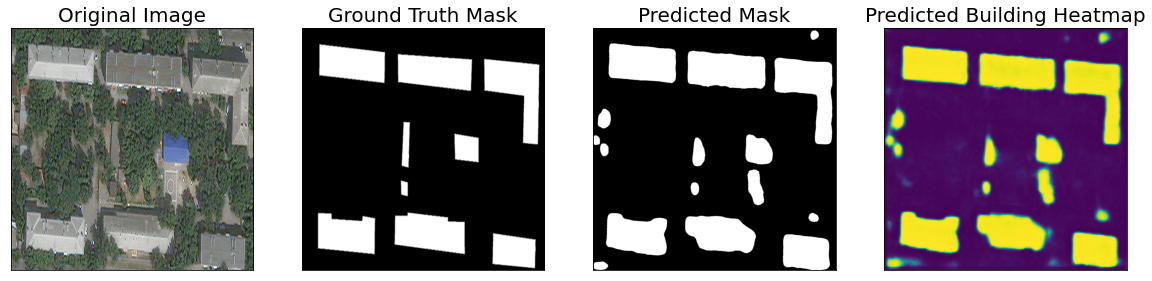

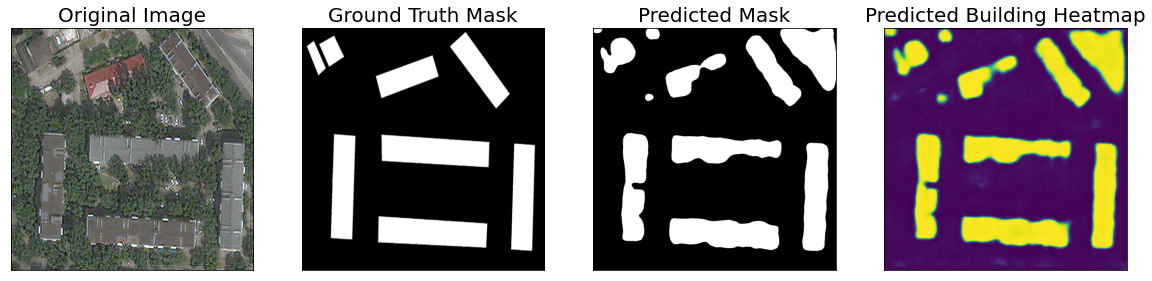

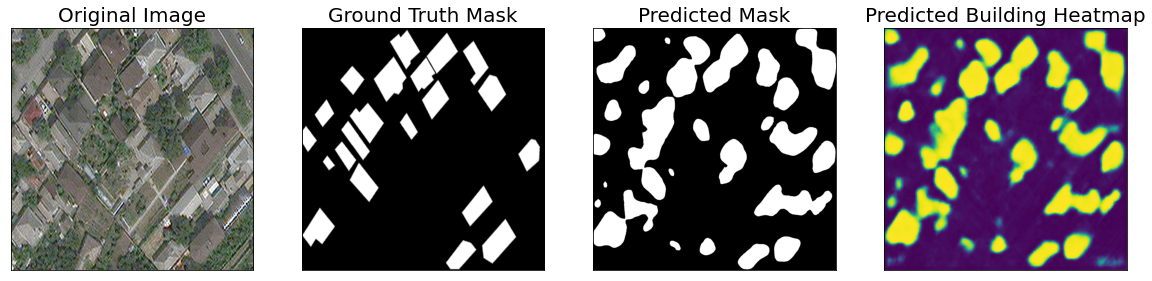

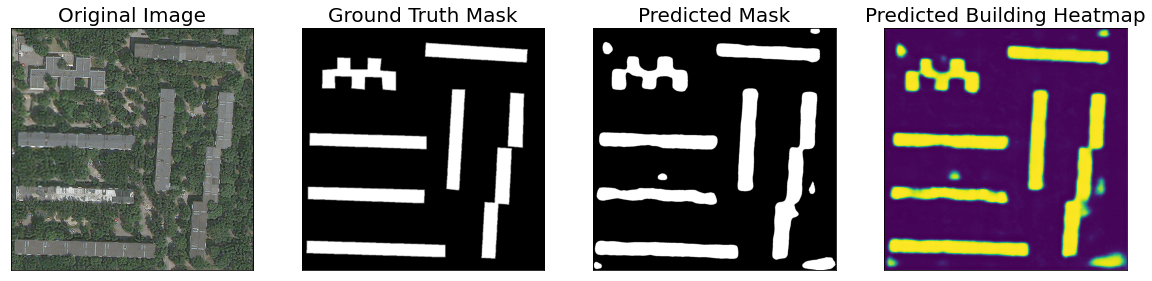

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s, dice_loss - 0.1324, iou_score - 0.8022]
Evaluation on Test Data: 
Mean IoU Score: 0.8022
Mean Dice Loss: 0.1324


### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4         5   \
dice_loss  0.508856  0.458952  0.432954  0.386902  0.361084  0.333654   
iou_score  0.306454  0.493285  0.536178  0.607161  0.621893  0.651017   

                 6         7         8         9   ...        70        71  \
dice_loss  0.308080  0.267166  0.273470  0.245719  ...  0.143236  0.125607   
iou_score  0.689425  0.750347  0.701938  0.753783  ...  0.783740  0.813592   

                 72        73        74        75        76        77  \
dice_loss  0.108279  0.142403  0.133149  0.132029  0.138735  0.170449   
iou_score  0.842559  0.784251  0.796864  0.796288  0.791157  0.735653   

                 78        79  
dice_loss  0.145873  0.158424  
iou_score  0.782989  0.754073  

[2 rows x 80 columns]

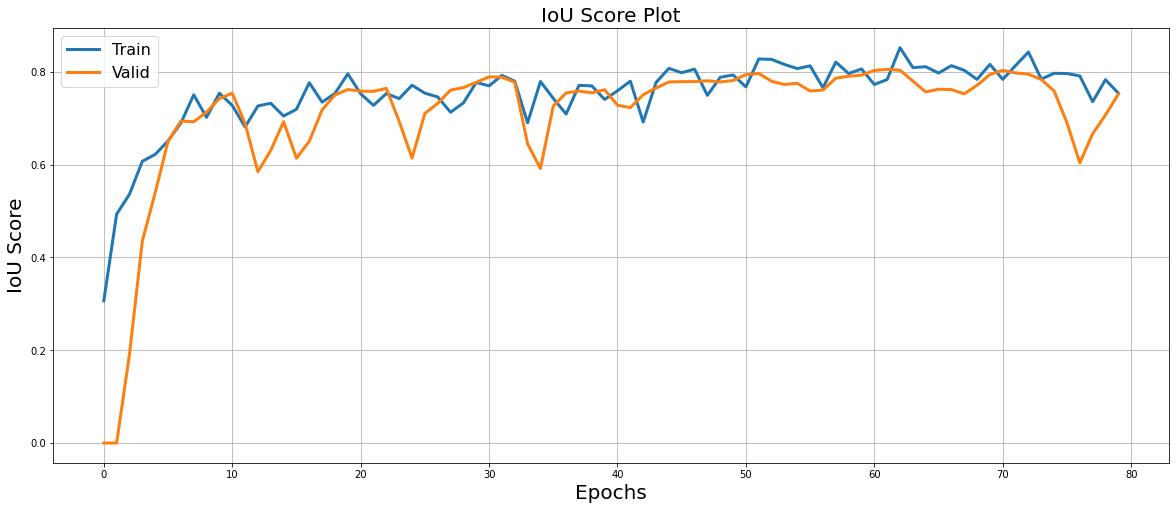

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

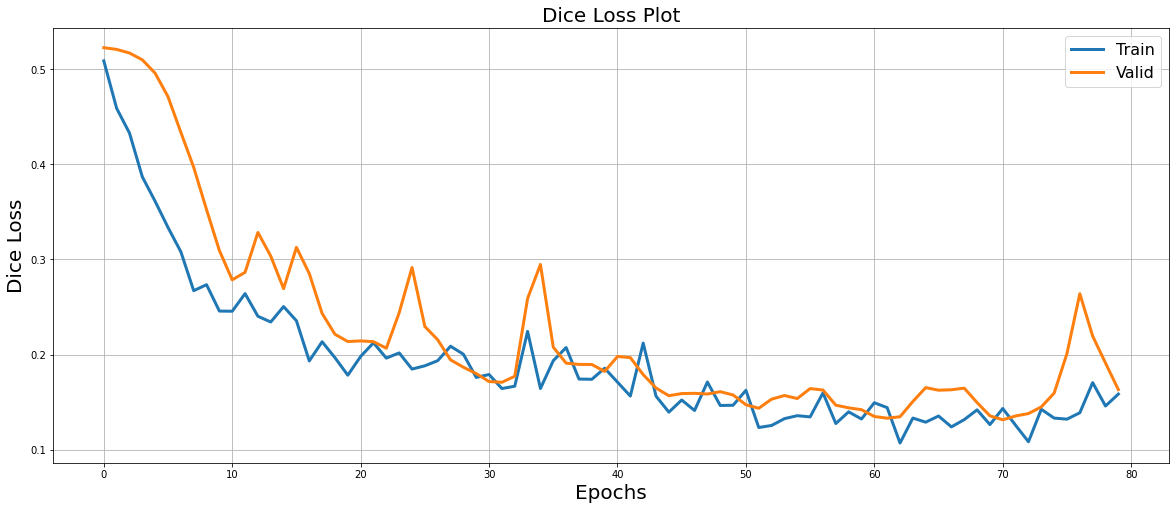

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()